In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)

In [8]:
try:
    data_df = pd.read_csv('/content/drive/MyDrive/DSP Project Data/EV_Charging_Data_NYC_Enhanced.csv')
    print('Data loaded successfully!')
    #display(data_df.head())
except FileNotFoundError:
    print("Error: The file was not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully!


In [17]:
data_df.date = pd.to_datetime(data_df.date)
data_df.connected_time_start_ts = pd.to_datetime(data_df.connected_time_start_ts)

In [18]:
data_df.head(3)

,date,station_name,location_name,driver_id,charge_duration_min,connected_duration_min,energy_provided_kwh,session_status,connected_time_start_ts,locality,temp,tempmax,tempmin,humidity,conditions,charge_duration_hours,days_between_charges,connected_slot,disconnected_slot
0,2025-05-23,BTCE0107,QFA - QUEENS FAMILY COURT MUNICIPAL GARAGE,00000000-0000-0000-0000-00FFCC439FD7,200.316667,200.316667,15.277,ROAMING,2025-05-23 07:21:35,QUEENS,54.1,63.6,48.6,75.5,"Rain, Overcast",3.0,0.0,morning,morning
1,2025-07-13,BTCE0107,QFA - QUEENS FAMILY COURT MUNICIPAL GARAGE,00000000-0000-0000-0000-00FFCC439FD7,3.666667,3.666667,0.364,ROAMING,2025-07-13 16:43:23,QUEENS,76.7,81.9,72.2,79.7,"Rain, Partially cloudy",0.0,51.0,afternoon,afternoon
2,2025-05-22,BTCE0098,QBO - QUEENS BOROUGH HALL MUNICIPAL PARKING GA...,00000000-0000-0000-0000-00FFCC44C9C3,365.116667,366.700000,36.817,ROAMING,2025-05-22 08:34:42,KEW GARDENS,50.4,52.4,48.7,85.0,"Rain, Overcast",6.0,0.0,morning,afternoon


In [19]:
numeric_cols = data_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data_df.select_dtypes(include=['category','object']).columns.tolist()

print('Numeric:', numeric_cols)
print('Categorical:', cat_cols)

Numeric: ['charge_duration_min', 'connected_duration_min', 'energy_provided_kwh', 'temp', 'tempmax', 'tempmin', 'humidity', 'charge_duration_hours', 'days_between_charges']
Categorical: ['station_name', 'location_name', 'driver_id', 'session_status', 'locality', 'conditions', 'connected_slot', 'disconnected_slot']


charge_duration_min {'skew': 7.991630688972833, 'used_log': True, 'clip_1pct': 1.083333333, 'clip_99pct': 1186.960333333217}
connected_duration_min {'skew': 6.4122537526627585, 'used_log': True, 'clip_1pct': 1.0843979998900002, 'clip_99pct': 1937.5370000001028}
energy_provided_kwh {'skew': 1.347291286455884, 'used_log': False, 'clip_1pct': 0.066, 'clip_99pct': 72.48062999999986}
temp {'skew': -0.2187956886195628, 'used_log': False, 'clip_1pct': 21.7, 'clip_99pct': 86.3}
tempmax {'skew': -0.2192798809895887, 'used_log': False, 'clip_1pct': 27.5, 'clip_99pct': 95.2}
tempmin {'skew': -0.2142207632950654, 'used_log': False, 'clip_1pct': 17.4, 'clip_99pct': 78.2}
humidity {'skew': 0.07315141036709776, 'used_log': False, 'clip_1pct': 25.867000000000008, 'clip_99pct': 90.0}
charge_duration_hours {'skew': 7.868839865244191, 'used_log': True, 'clip_1pct': 0.0, 'clip_99pct': 20.0}
days_between_charges {'skew': 9.350980246456524, 'used_log': True, 'clip_1pct': 0.0, 'clip_99pct': 208.0}


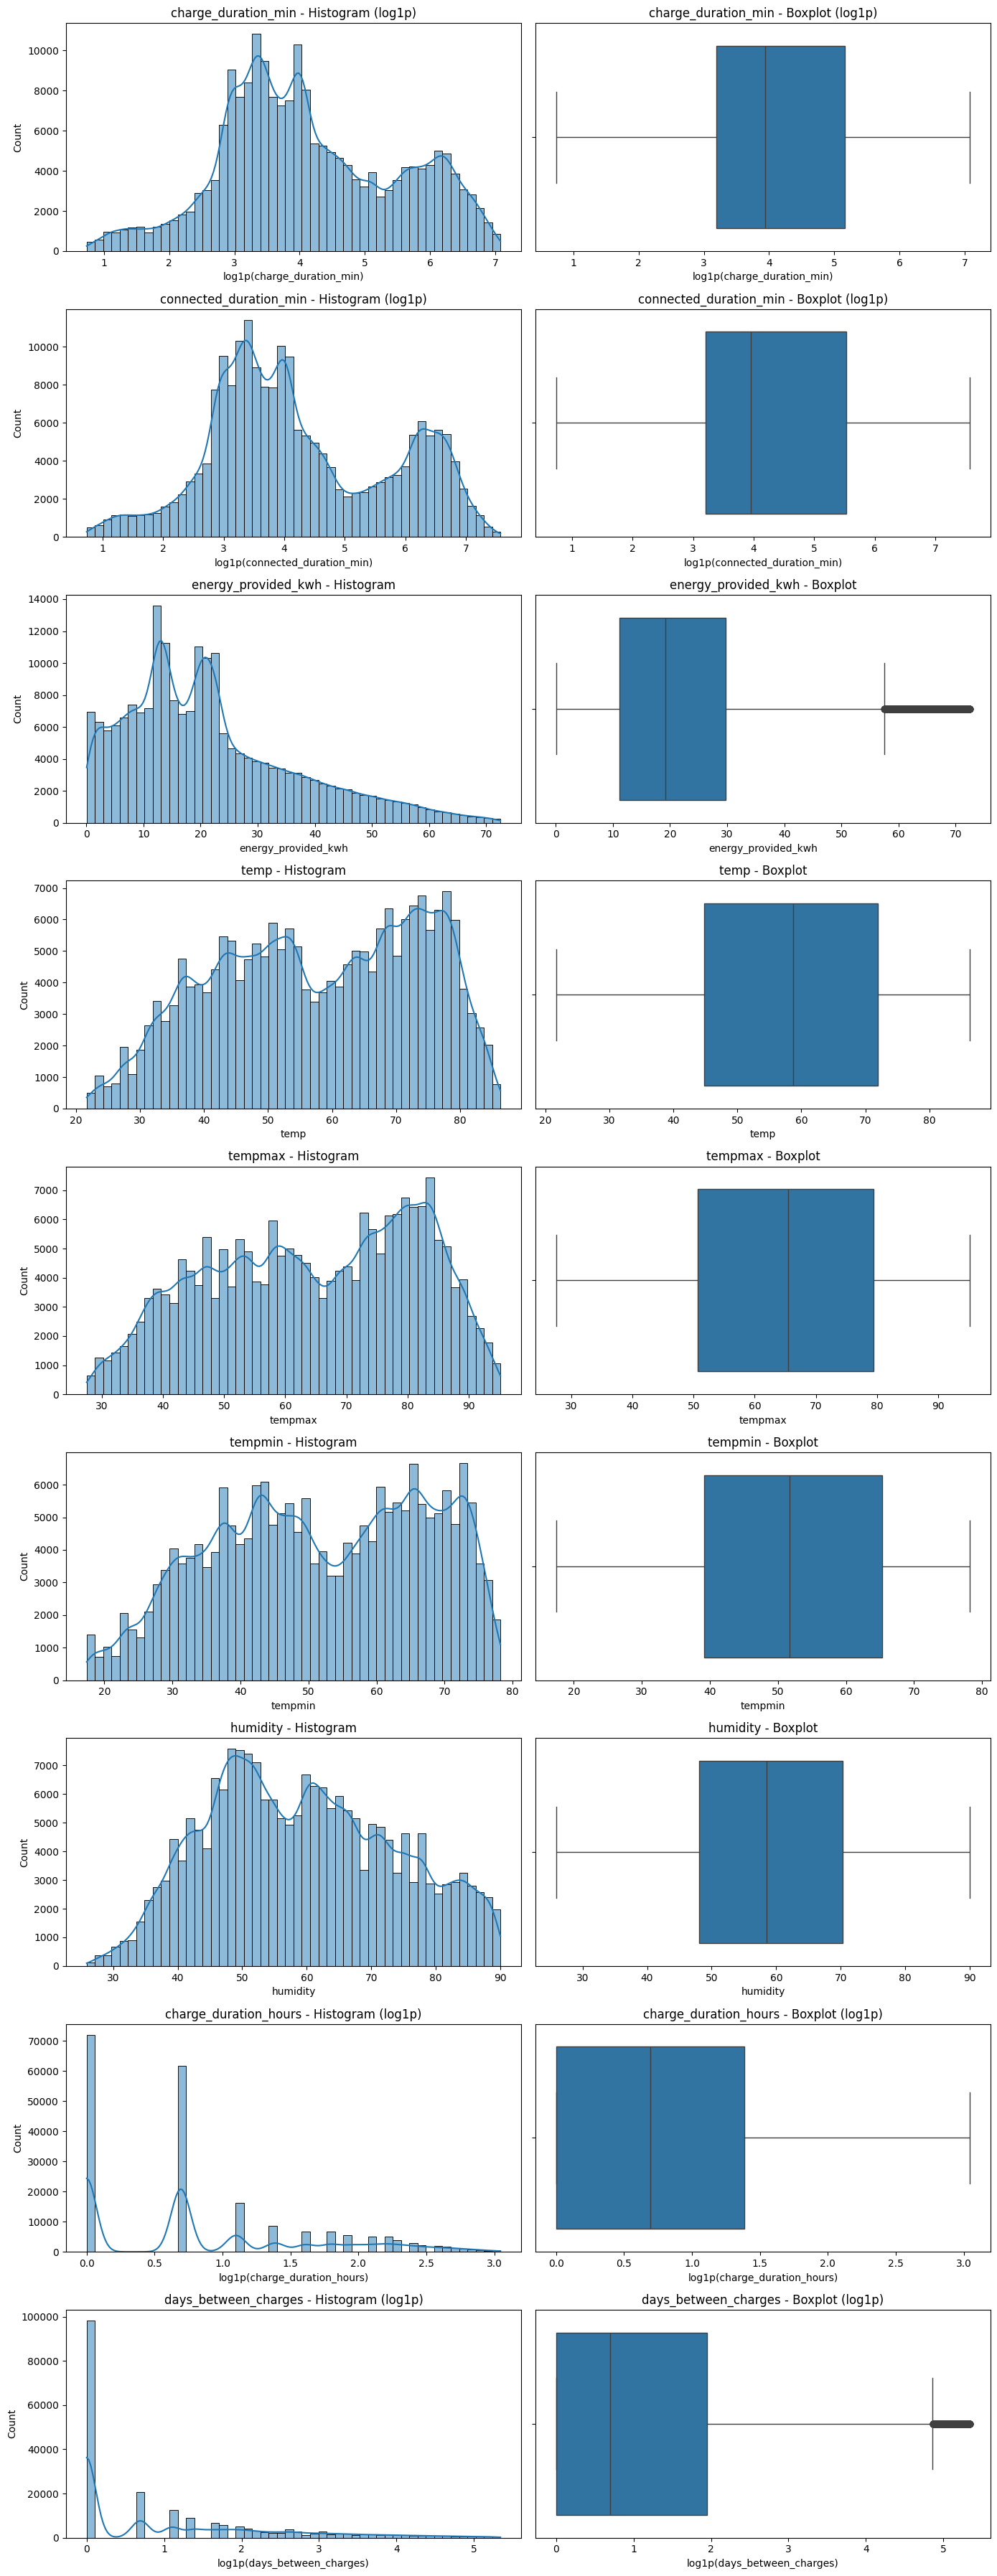

In [20]:
#Starting univariate analysis for numerical variables
def plot_univariate_linear(s, ax_hist, ax_box, bins=40, skew_threshold=2.0):
    lower = s.quantile(0.01)
    upper = s.quantile(0.99)
    s_clipped = s[(s >= lower) & (s <= upper)]
    skew_val = s.skew()
    use_log = skew_val > skew_threshold

    if use_log:
        s_plot = np.log1p(s_clipped)
        x_label = f"log1p({s.name})"
        hist_title = f"{s.name} - Histogram (log1p)"
        box_title = f"{s.name} - Boxplot (log1p)"
    else:
        s_plot = s_clipped
        x_label = s.name
        hist_title = f"{s.name} - Histogram"
        box_title = f"{s.name} - Boxplot"

    sns.histplot(s_plot, bins=bins, kde=True, ax=ax_hist)
    ax_hist.set_title(hist_title)
    ax_hist.set_xlabel(x_label)

    sns.boxplot(x=s_plot, ax=ax_box)
    ax_box.set_title(box_title)
    ax_box.set_xlabel(x_label)

    return {
    'skew': float(skew_val),
    'used_log': bool(use_log),
    'clip_1pct': float(lower),
    'clip_99pct': float(upper)
    }

n = len(numeric_cols)
fig, axes = plt.subplots(n, 2, figsize=(14, 4*n))

results = {}
for i, col in enumerate(numeric_cols):
    s = data_df[col].dropna()
    if s.size == 0:
        axes[i,0].text(0.5, 0.5, 'No data', ha='center', va='center')
        axes[i,1].text(0.5, 0.5, 'No data', ha='center', va='center')
        continue
    res = plot_univariate_linear(s, axes[i,0], axes[i,1], bins=50)
    results[col] = res

plt.tight_layout()
for k,v in list(results.items())[:10]:
    print(k, v)


Categorical cardinality and nulls:
              col  nunique  nnull
        driver_id    15977      0
     station_name      122      0
    location_name       16      0
       conditions       11      0
         locality        8      0
   connected_slot        6      0
disconnected_slot        6      0
   session_status        3      0

Categorical columns - Figure 1 of 2:

Categorical columns - Figure 2 of 2:


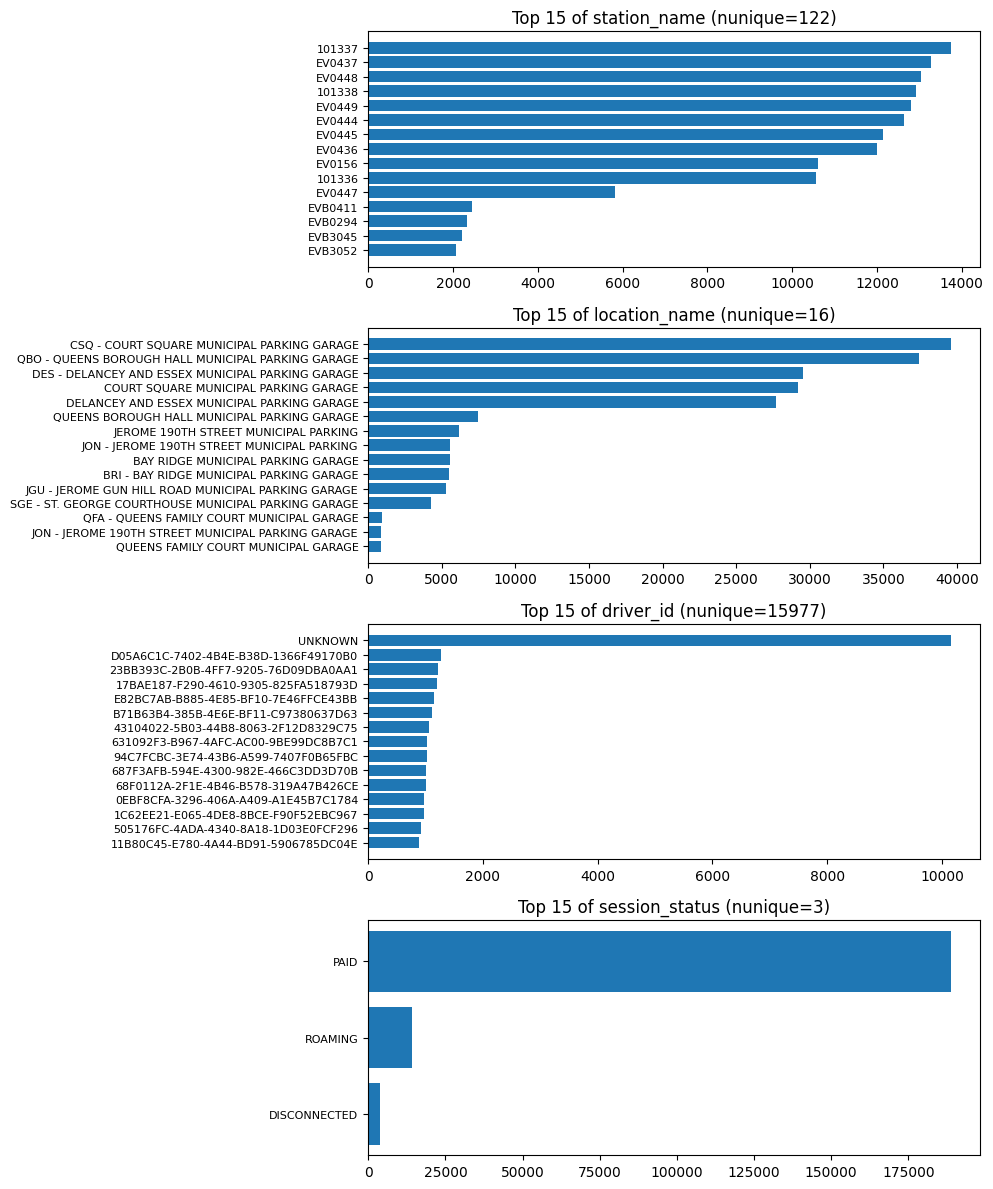

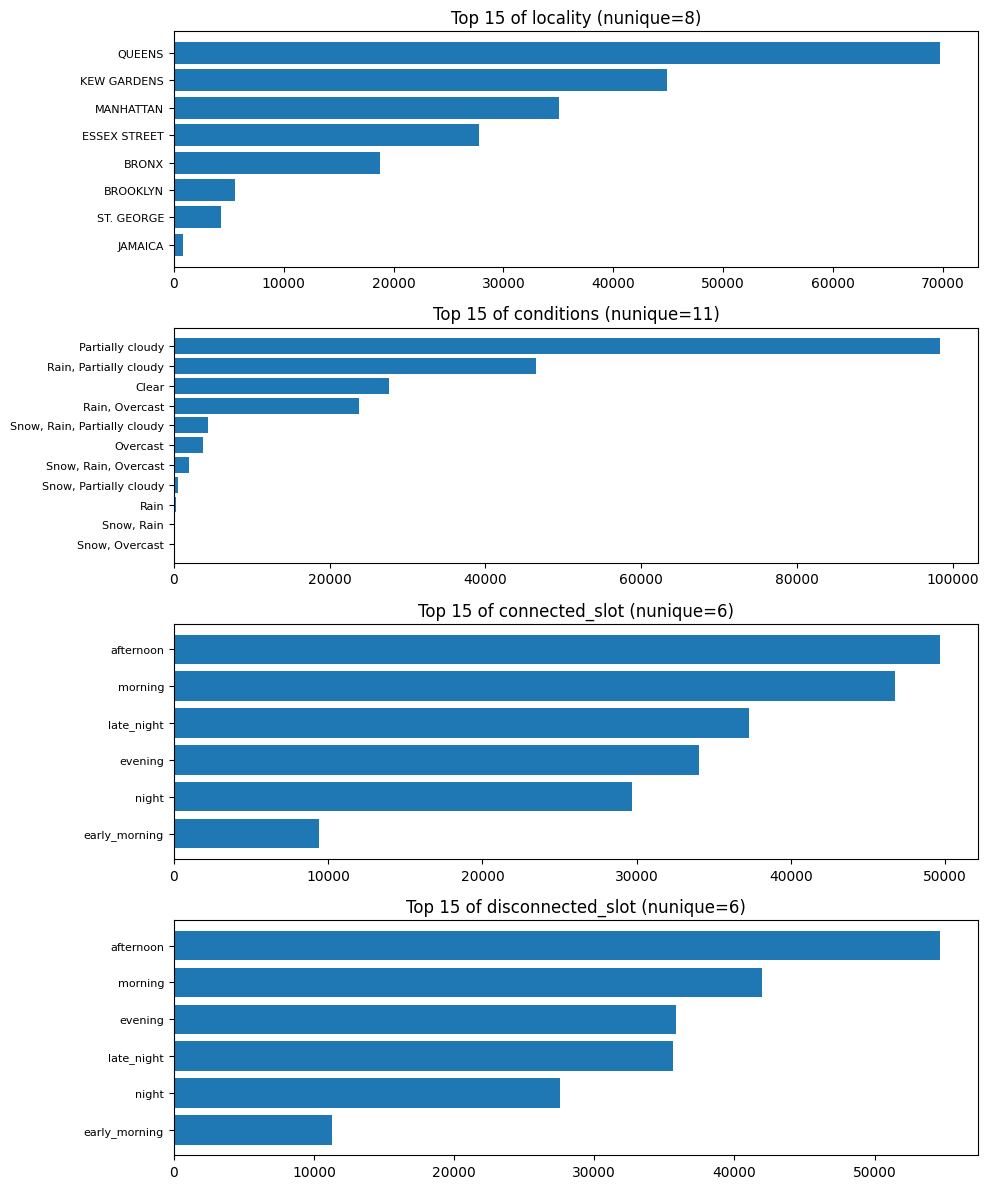

In [21]:
#Starting univariate analysis for categorical variables
K = 15
card_df = []
for c in cat_cols:
    nunique = data_df[c].nunique(dropna=False)
    nnull = data_df[c].isna().sum()
    card_df.append((c, nunique, nnull))
card_df = pd.DataFrame(card_df, columns=['col','nunique','nnull']).sort_values('nunique', ascending=False)
print('\nCategorical cardinality and nulls:')
print(card_df.to_string(index=False))


# Plot top-K counts for each categorical column
cols_per_fig = 4
groups = [cat_cols[i:i+cols_per_fig] for i in range(0, len(cat_cols), cols_per_fig)]
for gi, group in enumerate(groups):
    n = len(group)
    print(f'\nCategorical columns - Figure {gi+1} of {len(groups)}:')
    fig, axes = plt.subplots(n, 1, figsize=(10, 3*n))
    if n==1:
        axes = [axes]
    for ax, c in zip(axes, group):
        vc = data_df[c].value_counts(dropna=False).nlargest(K)
        ax.barh(vc.index.astype(str), vc.values)
        ax.set_title(f"Top {K} of {c} (nunique={data_df[c].nunique()})")
        ax.invert_yaxis()
        ax.tick_params(axis='y', labelsize=8)
    plt.tight_layout()

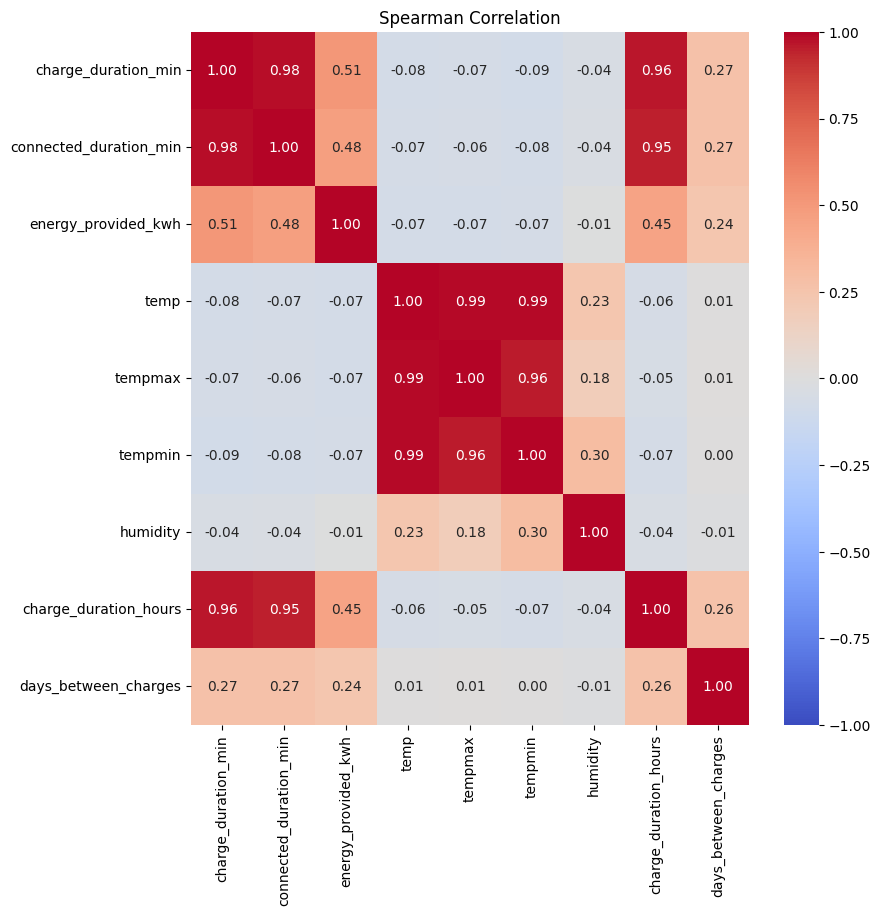

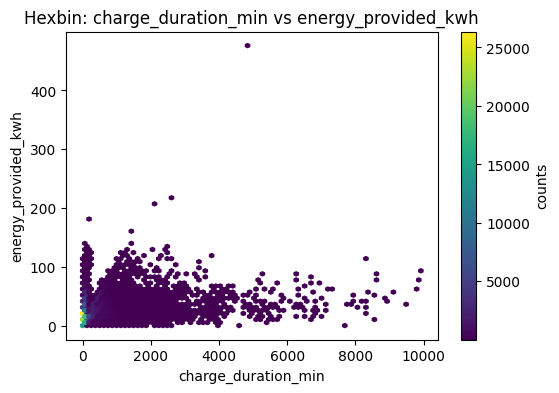

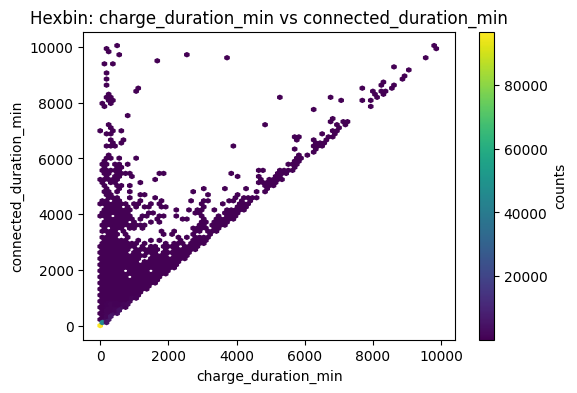

In [22]:
#Identifying correaltions between numeric columns
if len(numeric_cols) >= 2:
    corr = data_df[numeric_cols].corr(method='spearman')
    fig, ax = plt.subplots(figsize=(max(8, len(numeric_cols)), max(6, len(numeric_cols))))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
    ax.set_title('Spearman Correlation')

    # Hexbin examples for strong expected relationships
    pairs = [
    ('charge_duration_min', 'energy_provided_kwh'),
    ('charge_duration_min', 'connected_duration_min')
    ]
    for x,y in pairs:
        if x in data_df.columns and y in data_df.columns:
            fig, ax = plt.subplots(figsize=(6,4))
            ax.hexbin(data_df[x].dropna(), data_df[y].dropna(), gridsize=80, mincnt=1)
            ax.set_xlabel(x)
            ax.set_ylabel(y)
            ax.set_title(f'Hexbin: {x} vs {y}')
            cb = fig.colorbar(ax.collections[0], ax=ax)
            cb.set_label('counts')

Temporal analysis on connected_time_start_ts


Text(0.5, 1.0, 'Sessions by day of week (0=Mon)')

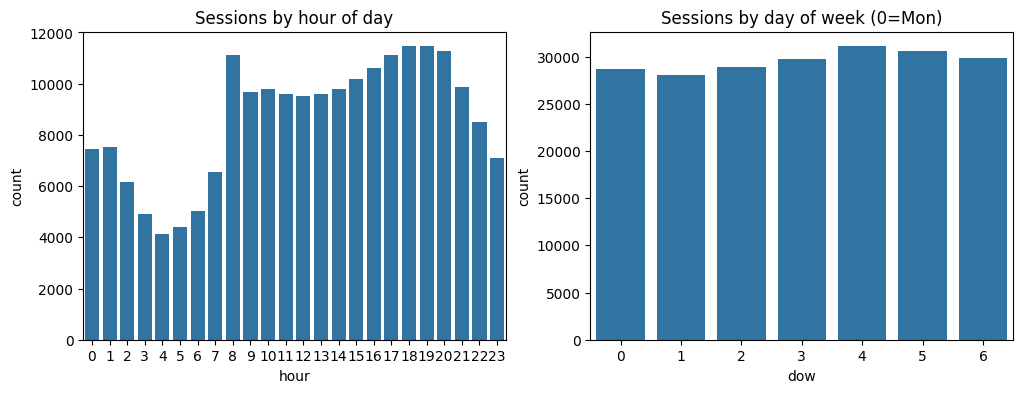

In [23]:
dt_cols = ['connected_time_start_ts']

tcol = dt_cols[0]
print('Temporal analysis on', tcol)
data_df['hour'] = data_df[tcol].dt.hour
data_df['dow'] = data_df[tcol].dt.dayofweek
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.countplot(data=data_df, x='hour', ax=ax[0])
ax[0].set_title('Sessions by hour of day')
sns.countplot(data=data_df, x='dow', ax=ax[1])
ax[1].set_title('Sessions by day of week (0=Mon)')

In [24]:
driver_agg_df = pd.DataFrame(data_df.groupby('driver_id').agg(
    sessions=('driver_id','count'),
    mean_charge_min=('charge_duration_min','mean'),
    median_charge_min=('charge_duration_min','median'),
    mean_energy_kwh=('energy_provided_kwh','mean'),
    median_energy_kwh=('energy_provided_kwh','median')
  ).sort_values('sessions', ascending=False)).reset_index()

driver_agg_df = driver_agg_df[driver_agg_df.driver_id != 'UNKNOWN']

In [25]:
driver_agg_df.head()

,driver_id,sessions,mean_charge_min,median_charge_min,mean_energy_kwh,median_energy_kwh
1,D05A6C1C-7402-4B4E-B38D-1366F49170B0,1270,374.661935,299.658333,19.288909,18.8170
2,23BB393C-2B0B-4FF7-9205-76D09DBA0AA1,1223,34.331875,33.833333,14.798256,19.0410
3,17BAE187-F290-4610-9305-825FA518793D,1199,127.634306,18.783333,14.103847,14.5830
4,E82BC7AB-B885-4E85-BF10-7E46FFCE43BB,1152,19.557966,18.829392,17.287666,19.7395
5,B71B63B4-385B-4E6E-BF11-C97380637D63,1113,15.104270,14.513950,14.491283,16.6600


In [ ]:
#Inferences

1. All duration-related variables are heavily right-skewed. This indicates many short/average sessions and very few extremely long sessions.
2. Charge duration and connection duration have multimodal patterns signifying different users have different charging preference.
3. Like duration, enery is also heavily right skewed, incidcating small number of charging events provide unusually large amounts of energy
4. Humidity distribution is more centralized indicating moderate weather most of the time.
5. Charge duration (hours) still remains skewed even after log-transform. Suggests a small population with very long charging sessions (overnight / long-stay parking).
6. Days between charges is extremely skewed. Most customers return within a very short interval (1–3 days), while some return after long gap.

7. QUEENS has the highest number of charging sessions (~70k), indicating it is the busiest EV charging locality.
8. JAMAICA, ST. GEORGE, and BROOKLYN have comparatively low counts, suggesting uneven charger demand across regions.
9. NYC has cloudy weather for most of the time.
10. Afternoon is the most common connected time slot, while morning being the second highest.
11. Disconnected slot distribution matches connected pattern.
12. Night-time and late-night disconnections are lower.
13. Most users disconnect after charging is complete, however few of them leave them for longer duration.
14. Most users charge for short sessions (<200 mins)
15. Most sessions deliver low energy (< 20 kWh)
16. Days_between_charges has slight positive correlation with duration.
